In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from collections import Counter

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts import project_functions

df = project_functions.load_and_process('..\..\data\data_raw\*.csv')

# Comparing word choice to number of review comments

An interesting question that arose while conducting our exploratory dataset analysis was whether a reviewer's word choice would garner feedback from other reviewers. Such that, were there specific words that would target or trigger a certain response? Did a negative review get more comments than a positive one?

To do this, we compared the review words to the number of review comments. As we have a large dataset, we focused on analyzing the reviews with more than 50 feedback responses. Below is a plot showing the review words that had most comments:

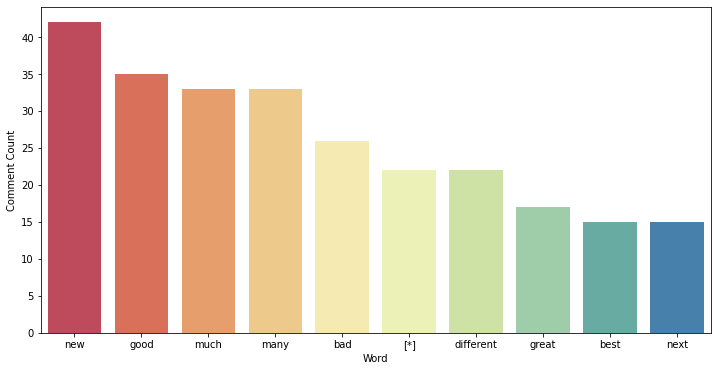

In [2]:
#Limiting data to only contain Review and Comment Count columns
rev_comments = df[['review', 'comment_count']]
data = pd.DataFrame({
    'Review': rev_comments['review'].astype(str),
    'Comment Count': pd.to_numeric(rev_comments['comment_count'])
})

#Keeping only the reviews with more than 50 comments
over50 = data[data['Comment Count'] > 50]

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, pos_tag_sents

a = Counter(" ".join(over50["Review"].str.lower()).split()).most_common()
stop_words = set(stopwords.words('english'))

#Filtering out meaningless words using NLTK's stop_words list
b = [(i[0],i[1]) for i in a if i[0] not in stop_words]

#Creating dataframe containing words and their counts
word_counts = pd.DataFrame(b, columns=['Word','Count'])

#Further filtering to only contain adjectives
word_counts['POSTags'] = pos_tag_sents(word_counts['Word'].apply(word_tokenize).tolist())
word_counts['POSTags'] = word_counts['POSTags'].astype(str)
final = word_counts[word_counts['POSTags'].str.contains("JJ")].head(10)

plt.figure(figsize=(12,6))
plot = sns.barplot(x=final['Word'], y=final['Count'], palette="Spectral")
plot.set(xlabel='Word', ylabel='Comment Count')
plt.show()

As we can see, mostly positive word choices would gain more comments. This is interesting to see as one may thing that negative reviews would gain **more** comments due to backlash from other users since we are analyzing the top games in each genre. But perhaps because these are top games, the ratio between positive and negative reviews is heavily unbalanced, thus the negative comments may get buried among all the positive reviews. 

Something else that we may need to take into consideration was that this analysis was based solely on individual words, which may skew the results of what we are aiming to know: the effect of the *positivity* or *negativity* of the review on comment count. 

What this means is that our analysis didn't take into the consideration of oxymorons like *amazingly awful, terribly good, etc.* in the reviews, which could affect the answer to our research question as now the meaning of the review has changed. Based on one of our exploratory data analyses, many of the reviews contained less than 10 characters, indicating most reviews would be straightfoward and concise. Thus, it is safe to assume that not many reviews would contain figures of speech like oxymorons.

However, it would still be good to compare it to the reviews' overall affinity score.

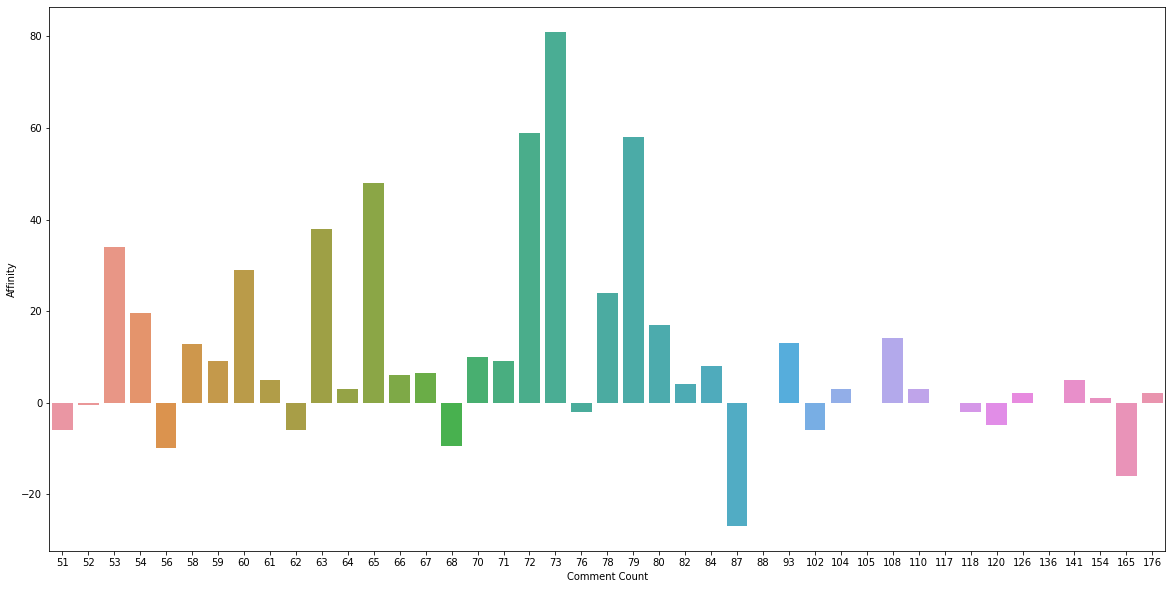

In [3]:
from afinn import Afinn
afinn = Afinn(language='en')

a_over50 = over50.copy()
a_over50['Affinity'] = a_over50['Review'].apply(afinn.score)

plt.figure(figsize=(20,10))
aplot = sns.barplot(x=a_over50['Comment Count'], y=a_over50['Affinity'], ci=None)
plt.show()

This graph shows the distribution of all the reviews with more than 50 comments and its affinity score. The affinity score is calculated based on the average of the review's words sentiment score - negative words have a negative score, positive words have a positive score, and neutral words have a score of zero.

Once again, we see that most reviews have a positive affinity score and make up for a large majority of comment counts. In addition, notice that the review with the second highest number of comments has an affinity score of approximately -15.0. This shows that our hypothesis (that negative reviews garner attention) is *somewhat* correct. 

What is even more interesting is that reviews with more than 100 comments, generally have a low (but positive) affinity score, with the highest score being approximately 10.0. Suprisingly, the highest number of comments has the second **lowest** positive affinity score, which is interesting to see as this means the review was positive but relatively neutral. This brings us to wonder, why did this review received so much user feedback?

In [22]:
top_review = over50[over50['Comment Count'] == 176]
with pd.option_context('display.max_colwidth', None, 'display.colheader_justify','left'):
    display(top_review.style.hide_index()
            .hide_columns(['Comment Count'])
            .set_properties(**{'text-align': 'left'})
            .set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])]))

Review
"This game saved my life. I am 27. My ex-wife and I have a daughter together, and adopted our son together. They are now both 4 years old. When we were going through our separation, I found myself lost and miserable. I was self destructive. I got so mad one day from everything spiraling out of my control that I punched some concrete in a moment of overwhelming emotion. That caused me to break my 5th metacarpal in my right hand... my working hand... my games hand.. the hand that I held and carried my children to bed with.. The hand I desperately needed to make sure I could continue to provide. After learning of the severity of my self-inflicted damage, I was borderline suicidal. Keep in mind that just a few months before this, I was the happiest man with no history of depression or anxiety. I have never had fits of rage, or been one to break down and cry, but I was in a low spot that just really buried me from being able to see the light on the other side. Having nothing better to do, I searched for a game I could play, ONE HANDED while I recovered. I somehow stumbled upon this game and read some of the reviews. I decided that it had to be worth a shot... I must admit, I didn't beat the game, or play nearly as long as some of you. In fact, I may have only played this game a day or two.. With that being said, after doing so, I had a new found joy and hope for life. I was able to put behind me the pain and suffering that had been cast over me. I was able to experience other peoples joy and happiness. I was able to see the fruits of my ""labor"". I relaxed for 5 fucking minutes to this music long enough to realize that I was going to be okay. After coming to that realization, I turned the game off, and I went back to work. It hurt my hand like hell but I was motivated. I stopped feeling so damn sorry for myself, and I became the father I needed to be in that moment, not the weak boy I was behaving as. Today, I am close friend with my kids mother. We don't fight, or argue, or say hurtful things to each other. We are parents, and friends. I now have 3 kids. My third child is, wait for it, ALSO 4 YEARS OLD. The woman I am with was going through a very similar situation at the time of my own separation, and we just stumbled in to each others life unexpectedly. We have been in a relationship for a year now, and are very happy together. Moral of the story, you never know what life holds in store for you, and if I would have given up when all the odds were stacked against me, I wouldn't be where I am today. This silly little game helped me realize that. Thank you ~EDIT~ A lot of people were upset I didn't share the things I enjoyed about the game in detail. Below you will find my personal experience in the short amount of time I spent playing. I spent most of my time fighting slimes with a sword and mining the ore in the dungeon.. haha, but I also made some money off plants. I didn't spend much time getting to know the townsfolk. I got irritated that weeds kept growing in my garden, but I kept plucking them and it was sort of rewarding to keep my map weed free. That's about all I can say other than digging up treasures that would show up in the dirt. I had just planted some plant that cost me like 1000 gold, and I built a water irrigation system around that, and my other plants. It was struck by lightning shortly after... lol, my best friend actually played for several hours with me which was unexpected, and since we shared gold he and I kept screwing each other over for fun. I just saw an update that may be fixing that ""issue"" however, and either way I intend to pick up the game again and play it much more in depth when my winter season comes and work slows down. My 20 hours of enjoyment."


What we find out is that the top commented review happens to be a very touching story of a man who was going through a tough experience that found new joy in his life after discovering a game. Unfortunately, we do not have the data containing the comment responses; however, judging from the bottom portion of the review, it seems that most of the comments were words of congratulations, questions, or critiques that the review was not focused on the gaming experience. 

From this, it makes more sense as to why the comment rate was so high and the affinity score was so low - rather than about the game, the reviewer talked mostly about his difficult life situation causing the affinity score to decrease significantly as it contained words such as *destructive, hurtful, etc.* which have very low sentimental scores. 

Overall, this analysis between the number of comments and the reviews' word choice and affinity score showed some very interesting results. And from this, we see there is some correlation between the positivity of the review and the amount of other user feedback, such that generally with top rated games, positive reviews garner more attention as others are able to relate to the reviewer, whether that may be from life experience or in-game experience. 